# Group 5K fold

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score
)
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
# CSV 
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/HR_Inten_5d_Z.csv'

# 
df = pd.read_csv(file_path, encoding="utf-8")

# Convert Time_24h to float hour
df["Time_24h"] = pd.to_datetime(df["Time_24h"], format="%H:%M", errors="coerce")
df["Time_24h"] = df["Time_24h"].dt.hour + df["Time_24h"].dt.minute / 60

X_columns = [
    "15m_G_Diff_5", "15m_G_Diff_6","15m_G_Diff_7","15m_G_Diff_8",
    "15m_G_Diff_9","15m_G_Diff_10",
    "Z_Previous_5","Z_Previous_6","Z_Previous_7","Z_Previous_8","Z_Previous_9","Z_Previous_10",
    "Time_24h", "hungry_weighted", "EMA_T_Diff",
    "mean_intensity_1h", "mean_intensity_2h", "mean_intensity_3h",
    "HR_mean_1h", "HR_mean_2h", "HR_mean_3h",
    "HR_std_1h", "HR_std_2h", "HR_std_3h",
    "HR_slope_1h", "HR_slope_2h", "HR_slope_3h",
    "TimeInBed", "Efficiency", "Sleep_Diff",
    "TimeInBed_isnull", "Efficiency_isnull", "Sleep_Diff_isnull",
    "hungry_weighted_isnull", "bored_weighted_isnull", "How_stressed_weighted_isnull",
    "How_anxious_weighted_isnull", "How_tired_weighted_isnull",
    "Glucose_range_pre_1_2.5h","Glucose_spread_ratio_pre_1_2.5h",
    "Glucose_skew_hint_pre_1_2.5h","Glucose_std_pre_1_2.5h",
    "Glucose_iqr_to_std_pre_1_2.5h",    
    "1_1.5h_pre_mean", "1_1.5h_pre_std", "1_1.5h_pre_slope",
    "1.5_2h_pre_mean", "1.5_2h_pre_std", "1.5_2h_pre_slope",
    "2_2.5h_pre_mean", "2_2.5h_pre_std", "2_2.5h_pre_slope",
    "Glucose_q25_pre_1_2.5h","Z_Previous_4","Z_HR", "Z_Intensity",
    "HR","Intensity"
    
]


# Remove rows with missing values
df_model = df[X_columns + ["GE_1h", "StudyID"]].dropna()

# 기본 데이터셋 준비 (기존과 동일)
df_model = df[X_columns + ["GE_1h", "StudyID"]].dropna()
X = df_model[X_columns]
y = df_model["GE_1h"].astype(int)
groups = df_model["StudyID"]

# GroupKFold 설정
gkf = GroupKFold(n_splits=5)

# 결과 저장용 리스트
metrics = []
feature_importance_list = []

threshold = 0.3  # 고정 threshold

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    print(f"\n📂 Fold {fold + 1}")

    X_train_raw, y_train_raw = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    # SMOTE 적용
    minority_class_size = np.bincount(y_train_raw)[1]
    k_neighbors = min(5, minority_class_size - 1) if minority_class_size > 1 else 1
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

    # 모델 학습
    model = RandomForestClassifier(
        n_estimators=1000,
        min_samples_split=50,
        min_samples_leaf=50,
        max_features=None,
        max_depth=50,
        criterion='entropy',
        class_weight=None,
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    # 예측 및 평가
    y_proba = model.predict_proba(X_val)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    metrics.append({
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred, zero_division=0),
        "Recall": recall_score(y_val, y_pred, zero_division=0),
        "F1": f1_score(y_val, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(y_val, y_proba),
        "PR AUC": average_precision_score(y_val, y_proba)
    })

    # Feature importance 저장
    feature_importance_list.append(model.feature_importances_)

# 평균 결과 출력
results_df = pd.DataFrame(metrics)
print("\n📊 GroupKFold (5-fold) 평균 성능:\n")
print(results_df.mean().round(4))

# Feature importance 평균
feature_importance_avg = np.mean(feature_importance_list, axis=0)
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importance_avg
}).sort_values("Importance", ascending=False)

print("\n🔍 평균 Feature Importance (Top 15):")
print(importances.head(15))



📂 Fold 1

📂 Fold 2

📂 Fold 3

📂 Fold 4

📂 Fold 5

📊 GroupKFold (5-fold) 평균 성능:

Accuracy     0.7221
Precision    0.1517
Recall       0.4121
F1           0.2210
ROC AUC      0.6563
PR AUC       0.1440
dtype: float64

🔍 평균 Feature Importance (Top 15):
              Feature  Importance
57          Intensity    0.218040
15  mean_intensity_1h    0.121114
13    hungry_weighted    0.063781
12           Time_24h    0.050034
44     1_1.5h_pre_std    0.042145
1        15m_G_Diff_6    0.042084
45   1_1.5h_pre_slope    0.039561
0        15m_G_Diff_5    0.037055
50     2_2.5h_pre_std    0.033791
47     1.5_2h_pre_std    0.033737
53       Z_Previous_4    0.029635
2        15m_G_Diff_7    0.021827
29         Sleep_Diff    0.020947
27          TimeInBed    0.018258
54               Z_HR    0.016307


# XGBoost

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score
)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# 1. Load Data
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/HR_Inten_5d_Z.csv'
df = pd.read_csv(file_path, encoding="utf-8")

# 2. Time conversion
df["Time_24h"] = pd.to_datetime(df["Time_24h"], format="%H:%M", errors="coerce")
df["Time_24h"] = df["Time_24h"].dt.hour + df["Time_24h"].dt.minute / 60

# 3. Features
X_columns = [
    "15m_G_Diff_5", "15m_G_Diff_6","15m_G_Diff_7","15m_G_Diff_8",
    "15m_G_Diff_9","15m_G_Diff_10",
    "Z_Previous_5","Z_Previous_6","Z_Previous_7","Z_Previous_8","Z_Previous_9","Z_Previous_10",
    "Time_24h", "hungry_weighted", "EMA_T_Diff",
    "mean_intensity_1h", "mean_intensity_2h", "mean_intensity_3h",
    "HR_mean_1h", "HR_mean_2h", "HR_mean_3h",
    "HR_std_1h", "HR_std_2h", "HR_std_3h",
    "HR_slope_1h", "HR_slope_2h", "HR_slope_3h",
    "TimeInBed", "Efficiency", "Sleep_Diff",
    "TimeInBed_isnull", "Efficiency_isnull", "Sleep_Diff_isnull",
    "hungry_weighted_isnull", "bored_weighted_isnull", "How_stressed_weighted_isnull",
    "How_anxious_weighted_isnull", "How_tired_weighted_isnull",
    "Glucose_range_pre_1_2.5h","Glucose_spread_ratio_pre_1_2.5h",
    "Glucose_skew_hint_pre_1_2.5h","Glucose_std_pre_1_2.5h",
    "Glucose_iqr_to_std_pre_1_2.5h",    
    "1_1.5h_pre_mean", "1_1.5h_pre_std", "1_1.5h_pre_slope",
    "1.5_2h_pre_mean", "1.5_2h_pre_std", "1.5_2h_pre_slope",
    "2_2.5h_pre_mean", "2_2.5h_pre_std", "2_2.5h_pre_slope",
    "Glucose_q25_pre_1_2.5h","Z_Previous_4","Z_HR", "Z_Intensity",
    "HR","Intensity"
]

# 4. Model DataFrame
df_model = df[X_columns + ["GE_1h", "StudyID"]].dropna()
X = df_model[X_columns]
y = df_model["GE_1h"].astype(int)
groups = df_model["StudyID"]

# 5. GroupKFold Cross-validation
gkf = GroupKFold(n_splits=5)
threshold = 0.3

metrics = []
feature_importance_list = []

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    print(f"\n📂 Fold {fold + 1}")

    X_train_raw, y_train_raw = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    # 6. SMOTE 적용
    minority_class_size = np.bincount(y_train_raw)[1]
    k_neighbors = min(5, minority_class_size - 1) if minority_class_size > 1 else 1
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

    # 7. XGBoost 모델
    model = XGBClassifier(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    # 8. 예측 및 평가
    y_proba = model.predict_proba(X_val)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    metrics.append({
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred, zero_division=0),
        "Recall": recall_score(y_val, y_pred, zero_division=0),
        "F1": f1_score(y_val, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(y_val, y_proba),
        "PR AUC": average_precision_score(y_val, y_proba)
    })

    # Feature importance
    feature_importance_list.append(model.feature_importances_)

# 9. 평균 결과
results_df = pd.DataFrame(metrics)
print("\n📊 GroupKFold (5-fold) 평균 성능:\n")
print(results_df.mean().round(4))

# 10. 평균 Feature Importance
feature_importance_avg = np.mean(feature_importance_list, axis=0)
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importance_avg
}).sort_values("Importance", ascending=False)

print("\n🔍 평균 Feature Importance (Top 15):")
print(importances.head(15))



📂 Fold 1

📂 Fold 2

📂 Fold 3

📂 Fold 4

📂 Fold 5

📊 GroupKFold (5-fold) 평균 성능:

Accuracy     0.8613
Precision    0.1909
Recall       0.1327
F1           0.1542
ROC AUC      0.6805
PR AUC       0.1616
dtype: float64

🔍 평균 Feature Importance (Top 15):
                         Feature  Importance
57                     Intensity    0.141957
50                2_2.5h_pre_std    0.060107
15             mean_intensity_1h    0.060010
44                1_1.5h_pre_std    0.053220
47                1.5_2h_pre_std    0.052319
13               hungry_weighted    0.042644
0                   15m_G_Diff_5    0.031847
48              1.5_2h_pre_slope    0.029863
45              1_1.5h_pre_slope    0.029264
2                   15m_G_Diff_7    0.028312
1                   15m_G_Diff_6    0.025614
40  Glucose_skew_hint_pre_1_2.5h    0.024580
12                      Time_24h    0.024564
54                          Z_HR    0.024150
3                   15m_G_Diff_8    0.023163


# LightGBM

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score
)
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from tqdm import tqdm

# Load CSV
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/HR_Inten_5d_Z.csv'
df = pd.read_csv(file_path, encoding="utf-8")

# Convert Time_24h to float hour
df["Time_24h"] = pd.to_datetime(df["Time_24h"], format="%H:%M", errors="coerce")
df["Time_24h"] = df["Time_24h"].dt.hour + df["Time_24h"].dt.minute / 60

X_columns = [
    "15m_G_Diff_5", "15m_G_Diff_6","15m_G_Diff_7","15m_G_Diff_8",
    "15m_G_Diff_9","15m_G_Diff_10",
    "Z_Previous_5","Z_Previous_6","Z_Previous_7","Z_Previous_8","Z_Previous_9","Z_Previous_10",
    "Time_24h", "hungry_weighted", "EMA_T_Diff",
    "mean_intensity_1h", "mean_intensity_2h", "mean_intensity_3h",
    "HR_mean_1h", "HR_mean_2h", "HR_mean_3h",
    "HR_std_1h", "HR_std_2h", "HR_std_3h",
    "HR_slope_1h", "HR_slope_2h", "HR_slope_3h",
    "TimeInBed", "Efficiency", "Sleep_Diff",
    "TimeInBed_isnull", "Efficiency_isnull", "Sleep_Diff_isnull",
    "hungry_weighted_isnull", "bored_weighted_isnull", "How_stressed_weighted_isnull",
    "How_anxious_weighted_isnull", "How_tired_weighted_isnull",
    "Glucose_range_pre_1_2.5h","Glucose_spread_ratio_pre_1_2.5h",
    "Glucose_skew_hint_pre_1_2.5h","Glucose_std_pre_1_2.5h",
    "Glucose_iqr_to_std_pre_1_2.5h",    
    "1_1.5h_pre_mean", "1_1.5h_pre_std", "1_1.5h_pre_slope",
    "1.5_2h_pre_mean", "1.5_2h_pre_std", "1.5_2h_pre_slope",
    "2_2.5h_pre_mean", "2_2.5h_pre_std", "2_2.5h_pre_slope",
    "Glucose_q25_pre_1_2.5h","Z_Previous_4","Z_HR", "Z_Intensity",
    "HR","Intensity"
]

# 모델 데이터 준비
df_model = df[X_columns + ["GE_1h", "StudyID"]].dropna()
X = df_model[X_columns]
y = df_model["GE_1h"].astype(int)
groups = df_model["StudyID"]

# GroupKFold 설정
gkf = GroupKFold(n_splits=5)
threshold = 0.3
metrics = []
feature_importance_list = []

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    print(f"\n📂 Fold {fold + 1}")

    X_train_raw, y_train_raw = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    # SMOTE 적용
    minority_class_size = np.bincount(y_train_raw)[1]
    k_neighbors = min(5, minority_class_size - 1) if minority_class_size > 1 else 1
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

    # LightGBM Dataset
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

    # 모델 파라미터
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'learning_rate': 0.03,
        'num_leaves': 31,
        'max_depth': 6,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'seed': 42,
        'n_jobs': -1
    }

    # 학습
    model = lgb.train(
    params,
    lgb_train,
    num_boost_round=500,
    valid_sets=[lgb_val]
    )

    # 예측 및 평가
    y_proba = model.predict(X_val)
    y_pred = (y_proba >= threshold).astype(int)

    metrics.append({
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred, zero_division=0),
        "Recall": recall_score(y_val, y_pred, zero_division=0),
        "F1": f1_score(y_val, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(y_val, y_proba),
        "PR AUC": average_precision_score(y_val, y_proba)
    })

    # Feature importance 저장
    feature_importance_list.append(model.feature_importance(importance_type='gain'))

# 평균 결과 출력
results_df = pd.DataFrame(metrics)
print("\n📊 GroupKFold (5-fold) 평균 성능:\n")
print(results_df.mean().round(4))

# 평균 Feature importance 출력
feature_importance_avg = np.mean(feature_importance_list, axis=0)
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importance_avg
}).sort_values("Importance", ascending=False)

print("\n🔍 평균 Feature Importance (Top 15):")
print(importances.head(15))



📂 Fold 1

📂 Fold 2

📂 Fold 3

📂 Fold 4

📂 Fold 5

📊 GroupKFold (5-fold) 평균 성능:

Accuracy     0.8670
Precision    0.1990
Recall       0.1237
F1           0.1506
ROC AUC      0.6770
PR AUC       0.1609
dtype: float64

🔍 평균 Feature Importance (Top 15):
                         Feature     Importance
57                     Intensity  100203.993551
44                1_1.5h_pre_std   70029.067871
50                2_2.5h_pre_std   66390.525828
47                1.5_2h_pre_std   63966.181352
15             mean_intensity_1h   59057.100287
0                   15m_G_Diff_5   35403.027871
12                      Time_24h   32318.492539
5                  15m_G_Diff_10   27482.542095
1                   15m_G_Diff_6   26275.006588
13               hungry_weighted   24328.831033
3                   15m_G_Diff_8   22671.233433
40  Glucose_skew_hint_pre_1_2.5h   20215.519111
2                   15m_G_Diff_7   20042.205245
54                          Z_HR   14644.481109
53                  Z_Previou

# Ensemble

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score
)
from imblearn.over_sampling import SMOTE
from collections import defaultdict

# CSV 불러오기
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/HR_Inten_5d_Z.csv'
df = pd.read_csv(file_path, encoding="utf-8")

# Time_24h 변환
df["Time_24h"] = pd.to_datetime(df["Time_24h"], format="%H:%M", errors="coerce")
df["Time_24h"] = df["Time_24h"].dt.hour + df["Time_24h"].dt.minute / 60

# Feature columns
X_columns = [
    "15m_G_Diff_5", "15m_G_Diff_6", "15m_G_Diff_7", "15m_G_Diff_8",
    "15m_G_Diff_9", "15m_G_Diff_10",
    "Z_Previous_5", "Z_Previous_6", "Z_Previous_7", "Z_Previous_8", "Z_Previous_9", "Z_Previous_10",
    "Time_24h", "hungry_weighted", "EMA_T_Diff",
    "mean_intensity_1h", "mean_intensity_2h", "mean_intensity_3h",
    "HR_mean_1h", "HR_mean_2h", "HR_mean_3h",
    "HR_std_1h", "HR_std_2h", "HR_std_3h",
    "HR_slope_1h", "HR_slope_2h", "HR_slope_3h",
    "TimeInBed", "Efficiency", "Sleep_Diff",
    "TimeInBed_isnull", "Efficiency_isnull", "Sleep_Diff_isnull",
    "hungry_weighted_isnull", "bored_weighted_isnull", "How_stressed_weighted_isnull",
    "How_anxious_weighted_isnull", "How_tired_weighted_isnull",
    "Glucose_range_pre_1_2.5h", "Glucose_spread_ratio_pre_1_2.5h",
    "Glucose_skew_hint_pre_1_2.5h", "Glucose_std_pre_1_2.5h",
    "Glucose_iqr_to_std_pre_1_2.5h",    
    "1_1.5h_pre_mean", "1_1.5h_pre_std", "1_1.5h_pre_slope",
    "1.5_2h_pre_mean", "1.5_2h_pre_std", "1.5_2h_pre_slope",
    "2_2.5h_pre_mean", "2_2.5h_pre_std", "2_2.5h_pre_slope",
    "Glucose_q25_pre_1_2.5h", "Z_Previous_4", "Z_HR", "Z_Intensity",
    "HR", "Intensity"
]

# 결측치 제거
df_model = df[X_columns + ["GE_1h", "StudyID"]].dropna()
X = df_model[X_columns]
y = df_model["GE_1h"].astype(int)
groups = df_model["StudyID"]

# GroupKFold 설정
gkf = GroupKFold(n_splits=5)
threshold = 0.3

# 결과 저장용
metrics = []
feature_importances = defaultdict(list)

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    print(f"\n📂 Fold {fold + 1}")

    X_train_raw, y_train_raw = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    # SMOTE 적용
    minority_class_size = np.bincount(y_train_raw)[1]
    k_neighbors = min(5, minority_class_size - 1) if minority_class_size > 1 else 1
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

    # 개별 모델 정의
    rf = RandomForestClassifier(
        n_estimators=1000, max_depth=50, min_samples_split=50, min_samples_leaf=50,
        criterion='entropy', n_jobs=-1, random_state=42
    )
    xgb = XGBClassifier(
        n_estimators=500, max_depth=5, learning_rate=0.05, use_label_encoder=False,
        eval_metric='logloss', n_jobs=-1, random_state=42
    )
    lgb = LGBMClassifier(
        n_estimators=500, max_depth=5, learning_rate=0.05, n_jobs=-1, random_state=42
    )

    # VotingClassifier 정의
    ensemble = VotingClassifier(
        estimators=[("rf", rf), ("xgb", xgb), ("lgb", lgb)],
        voting='soft', n_jobs=-1
    )

    ensemble.fit(X_train, y_train)
    y_proba = ensemble.predict_proba(X_val)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    # 성능 저장
    metrics.append({
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred, zero_division=0),
        "Recall": recall_score(y_val, y_pred, zero_division=0),
        "F1": f1_score(y_val, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(y_val, y_proba),
        "PR AUC": average_precision_score(y_val, y_proba)
    })

    # 각 모델의 feature importance 저장
    fitted_rf = ensemble.estimators_[0]
    fitted_xgb = ensemble.estimators_[1]
    fitted_lgb = ensemble.estimators_[2]

    feature_importances["rf"].append(fitted_rf.feature_importances_)
    feature_importances["xgb"].append(fitted_xgb.feature_importances_)
    feature_importances["lgb"].append(fitted_lgb.feature_importances_)

# 평균 성능 출력
results_df = pd.DataFrame(metrics)
print("\n📊 GroupKFold (5-fold) 평균 성능:\n")
print(results_df.mean().round(4))

# 평균 feature importance
for model_name in feature_importances:
    avg_importance = np.mean(feature_importances[model_name], axis=0)
    top_features = pd.DataFrame({
        "Feature": X.columns,
        "Importance": avg_importance
    }).sort_values("Importance", ascending=False).head(15)
    
    print(f"\n🔍 Top 15 Feature Importance - {model_name.upper()}")
    print(top_features)



📂 Fold 1
[LightGBM] [Info] Number of positive: 24948, number of negative: 24948
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12523
[LightGBM] [Info] Number of data points in the train set: 49896, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

# 10fold RF

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score
)
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
# CSV 
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/HR_Inten_5d_Z.csv'

# 
df = pd.read_csv(file_path, encoding="utf-8")

# Convert Time_24h to float hour
df["Time_24h"] = pd.to_datetime(df["Time_24h"], format="%H:%M", errors="coerce")
df["Time_24h"] = df["Time_24h"].dt.hour + df["Time_24h"].dt.minute / 60

X_columns = [
    "15m_G_Diff_5", "15m_G_Diff_6","15m_G_Diff_7","15m_G_Diff_8",
    "15m_G_Diff_9","15m_G_Diff_10",
    "Z_Previous_5","Z_Previous_6","Z_Previous_7","Z_Previous_8","Z_Previous_9","Z_Previous_10",
    "Time_24h", "hungry_weighted", "EMA_T_Diff",
    "mean_intensity_1h", "mean_intensity_2h", "mean_intensity_3h",
    "HR_mean_1h", "HR_mean_2h", "HR_mean_3h",
    "HR_std_1h", "HR_std_2h", "HR_std_3h",
    "HR_slope_1h", "HR_slope_2h", "HR_slope_3h",
    "TimeInBed", "Efficiency", "Sleep_Diff",
    "TimeInBed_isnull", "Efficiency_isnull", "Sleep_Diff_isnull",
    "hungry_weighted_isnull", "bored_weighted_isnull", "How_stressed_weighted_isnull",
    "How_anxious_weighted_isnull", "How_tired_weighted_isnull",
    "Glucose_range_pre_1_2.5h","Glucose_spread_ratio_pre_1_2.5h",
    "Glucose_skew_hint_pre_1_2.5h","Glucose_std_pre_1_2.5h",
    "Glucose_iqr_to_std_pre_1_2.5h",    
    "1_1.5h_pre_mean", "1_1.5h_pre_std", "1_1.5h_pre_slope",
    "1.5_2h_pre_mean", "1.5_2h_pre_std", "1.5_2h_pre_slope",
    "2_2.5h_pre_mean", "2_2.5h_pre_std", "2_2.5h_pre_slope",
    "Glucose_q25_pre_1_2.5h","Z_Previous_4","Z_HR", "Z_Intensity",
    "HR","Intensity"
    
]


# Remove rows with missing values
df_model = df[X_columns + ["GE_1h", "StudyID"]].dropna()

# 기본 데이터셋 준비 (기존과 동일)
df_model = df[X_columns + ["GE_1h", "StudyID"]].dropna()
X = df_model[X_columns]
y = df_model["GE_1h"].astype(int)
groups = df_model["StudyID"]

# GroupKFold 설정
gkf = GroupKFold(n_splits=10)

# 결과 저장용 리스트
metrics = []
feature_importance_list = []

threshold = 0.3  # 고정 threshold

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    print(f"\n📂 Fold {fold + 1}")

    X_train_raw, y_train_raw = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    # SMOTE 적용
    minority_class_size = np.bincount(y_train_raw)[1]
    k_neighbors = min(5, minority_class_size - 1) if minority_class_size > 1 else 1
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

    # 모델 학습
    model = RandomForestClassifier(
        n_estimators=1000,
        min_samples_split=50,
        min_samples_leaf=50,
        max_features=None,
        max_depth=50,
        criterion='entropy',
        class_weight=None,
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    # 예측 및 평가
    y_proba = model.predict_proba(X_val)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    metrics.append({
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred, zero_division=0),
        "Recall": recall_score(y_val, y_pred, zero_division=0),
        "F1": f1_score(y_val, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(y_val, y_proba),
        "PR AUC": average_precision_score(y_val, y_proba)
    })

    # Feature importance 저장
    feature_importance_list.append(model.feature_importances_)

# 평균 결과 출력
results_df = pd.DataFrame(metrics)
print("\n📊 GroupKFold (5-fold) 평균 성능:\n")
print(results_df.mean().round(4))

# Feature importance 평균
feature_importance_avg = np.mean(feature_importance_list, axis=0)
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importance_avg
}).sort_values("Importance", ascending=False)

print("\n🔍 평균 Feature Importance (Top 15):")
print(importances.head(15))


📂 Fold 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:47:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/jupyter_env/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [22:51:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

# Train w/10D + 4D validation

In [267]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score
)
from imblearn.over_sampling import SMOTE

# Load CSV
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/HR_Inten_5d_Z.csv'
df = pd.read_csv(file_path, encoding="utf-8")

# Convert Time_24h to float
df["Time_24h"] = pd.to_datetime(df["Time_24h"], format="%H:%M", errors="coerce")
df["Time_24h"] = df["Time_24h"].dt.hour + df["Time_24h"].dt.minute / 60

# Feature columns
X_columns = [
    "15m_G_Diff_5", "15m_G_Diff_6","15m_G_Diff_7","15m_G_Diff_8",
    "15m_G_Diff_9","15m_G_Diff_10",
    "Z_Previous_5","Z_Previous_6","Z_Previous_7","Z_Previous_8","Z_Previous_9","Z_Previous_10",
    "Time_24h", "hungry_weighted", "EMA_T_Diff",
    "mean_intensity_1h", "mean_intensity_2h", "mean_intensity_3h",
    "HR_mean_1h", "HR_mean_2h", "HR_mean_3h",
    "HR_std_1h", "HR_std_2h", "HR_std_3h",
    "HR_slope_1h", "HR_slope_2h", "HR_slope_3h",
    "TimeInBed", "Efficiency", "Sleep_Diff",
    "TimeInBed_isnull", "Efficiency_isnull", "Sleep_Diff_isnull",
    "hungry_weighted_isnull", "bored_weighted_isnull", "How_stressed_weighted_isnull",
    "How_anxious_weighted_isnull", "How_tired_weighted_isnull",
    "Glucose_range_pre_1_2.5h","Glucose_spread_ratio_pre_1_2.5h",
    "Glucose_skew_hint_pre_1_2.5h","Glucose_std_pre_1_2.5h",
    "Glucose_iqr_to_std_pre_1_2.5h",    
    "1_1.5h_pre_mean", "1_1.5h_pre_std", "1_1.5h_pre_slope",
    "1.5_2h_pre_mean", "1.5_2h_pre_std", "1.5_2h_pre_slope",
    "2_2.5h_pre_mean", "2_2.5h_pre_std", "2_2.5h_pre_slope",
    "Glucose_q25_pre_1_2.5h","Z_Previous_4","Z_HR", "Z_Intensity",
    "HR","Intensity"
]

# Drop missing
df_model = df[X_columns + ["GE_1h", "Relative_Day", "StudyID"]].dropna()

# Train / Test split by Relative_Day
train_df = df_model[df_model["Relative_Day"] <= 10]
test_df  = df_model[df_model["Relative_Day"] >= 11]

X_train_raw = train_df[X_columns]
y_train_raw = train_df["GE_1h"].astype(int)

X_test = test_df[X_columns]
y_test = test_df["GE_1h"].astype(int)

# Apply SMOTE
minority_class_size = np.bincount(y_train_raw)[1]
k_neighbors = min(5, minority_class_size - 1) if minority_class_size > 1 else 1
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

# Train model
model = RandomForestClassifier(
    n_estimators=1000,
    min_samples_split=50,
    min_samples_leaf=50,
    max_features=None,
    max_depth=50,
    criterion='entropy',
    class_weight=None,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Predict
threshold = 0.3
y_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= threshold).astype(int)

# Evaluate
results = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, zero_division=0),
    "Recall": recall_score(y_test, y_pred, zero_division=0),
    "F1": f1_score(y_test, y_pred, zero_division=0),
    "ROC AUC": roc_auc_score(y_test, y_proba),
    "PR AUC": average_precision_score(y_test, y_proba)
}

print("\n🧪 Temporal Split (Day 1–10 Train, Day 11–14 Test) Evaluation:\n")
for metric, value in results.items():
    print(f"{metric:<10}: {value:.4f}")

# Feature importance
importances = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=False)

print("\n🔍 Feature Importance (Top 15):")
print(importances.head(15))



🧪 Temporal Split (Day 1–10 Train, Day 11–14 Test) Evaluation:

Accuracy  : 0.7053
Precision : 0.1467
Recall    : 0.4921
F1        : 0.2260
ROC AUC   : 0.6686
PR AUC    : 0.1420

🔍 Feature Importance (Top 15):
             Feature  Importance
57         Intensity    0.235339
12          Time_24h    0.145837
13   hungry_weighted    0.066147
0       15m_G_Diff_5    0.064341
1       15m_G_Diff_6    0.041326
45  1_1.5h_pre_slope    0.039481
53      Z_Previous_4    0.038914
54              Z_HR    0.028177
44    1_1.5h_pre_std    0.027697
2       15m_G_Diff_7    0.026175
29        Sleep_Diff    0.017404
4       15m_G_Diff_9    0.015041
47    1.5_2h_pre_std    0.013615
55       Z_Intensity    0.013544
27         TimeInBed    0.012876



📊 Threshold별 성능 비교:

    Threshold  Accuracy  Precision  Recall      F1  ROC AUC  PR AUC
0        0.25    0.6171     0.1347  0.6230  0.2215   0.6686   0.142
1        0.26    0.6350     0.1357  0.5915  0.2208   0.6686   0.142
2        0.27    0.6521     0.1374  0.5645  0.2210   0.6686   0.142
3        0.28    0.6708     0.1408  0.5422  0.2236   0.6686   0.142
4        0.29    0.6888     0.1433  0.5144  0.2242   0.6686   0.142
5        0.30    0.7053     0.1467  0.4921  0.2260   0.6686   0.142
6        0.31    0.7192     0.1482  0.4661  0.2249   0.6686   0.142
7        0.32    0.7337     0.1481  0.4308  0.2205   0.6686   0.142
8        0.33    0.7477     0.1513  0.4095  0.2210   0.6686   0.142
9        0.34    0.7590     0.1501  0.3770  0.2148   0.6686   0.142
10       0.35    0.7695     0.1495  0.3491  0.2094   0.6686   0.142
11       0.36    0.7801     0.1489  0.3213  0.2035   0.6686   0.142
12       0.37    0.7895     0.1457  0.2897  0.1939   0.6686   0.142
13       0.38    0.7985   

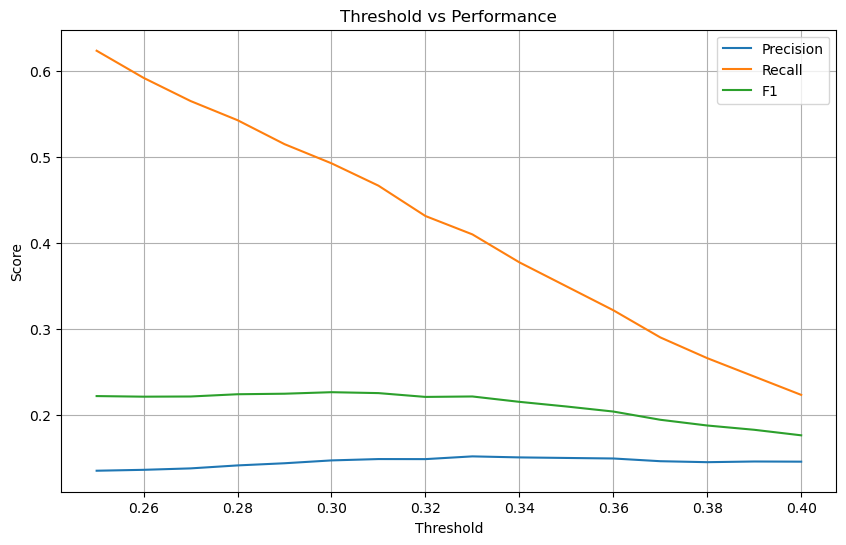

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score
)

# 다양한 threshold 범위 설정
thresholds = np.arange(0.25, 0.41, 0.01)  # 0.25 ~ 0.40

results_threshold = []

for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    results_threshold.append({
        "Threshold": round(thresh, 2),
        "Accuracy": accuracy_score(y_test, y_pred_thresh),
        "Precision": precision_score(y_test, y_pred_thresh, zero_division=0),
        "Recall": recall_score(y_test, y_pred_thresh, zero_division=0),
        "F1": f1_score(y_test, y_pred_thresh, zero_division=0),
        "ROC AUC": roc_auc_score(y_test, y_proba),
        "PR AUC": average_precision_score(y_test, y_proba)
    })

# 결과 출력
df_thresholds = pd.DataFrame(results_threshold)
print("\n📊 Threshold별 성능 비교:\n")
print(df_thresholds.round(4))

# 시각화 (옵션)
plt.figure(figsize=(10, 6))
plt.plot(df_thresholds["Threshold"], df_thresholds["Precision"], label="Precision")
plt.plot(df_thresholds["Threshold"], df_thresholds["Recall"], label="Recall")
plt.plot(df_thresholds["Threshold"], df_thresholds["F1"], label="F1")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Performance")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
# 🟩 1. sample & GE counts
def summarize_split(df, name):
    total = len(df)
    ge_1 = (df["GE_1h"] == 1).sum()
    ge_0 = (df["GE_1h"] == 0).sum()
    print(f"\n📊 {name} Set Summary")
    print(f"Total samples      : {total}")
    print(f"GE = 1 count       : {ge_1} ({ge_1 / total:.2%})")
    print(f"GE = 0 count       : {ge_0} ({ge_0 / total:.2%})")
    print(f"Relative Day range : {sorted(df['Relative_Day'].unique())}")

summarize_split(train_df, "Train (Day 1–10)")
summarize_split(test_df,  "Test  (Day 11–14)")



📊 Train (Day 1–10) Set Summary
Total samples      : 22253
GE = 1 count       : 2230 (10.02%)
GE = 0 count       : 20023 (89.98%)
Relative Day range : [6, 7, 8, 9, 10]

📊 Test  (Day 11–14) Set Summary
Total samples      : 12321
GE = 1 count       : 1077 (8.74%)
GE = 0 count       : 11244 (91.26%)
Relative Day range : [11, 12, 13, 14]


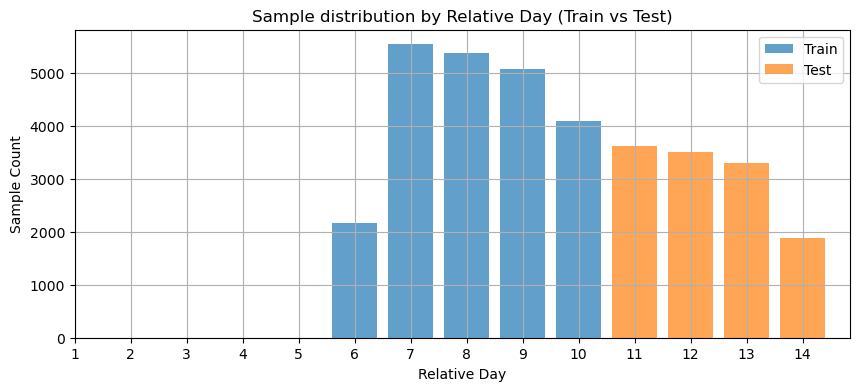

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
train_counts = train_df["Relative_Day"].value_counts().sort_index()
test_counts = test_df["Relative_Day"].value_counts().sort_index()

plt.bar(train_counts.index, train_counts.values, label="Train", alpha=0.7)
plt.bar(test_counts.index, test_counts.values, label="Test", alpha=0.7)
plt.xticks(range(1, 15))
plt.xlabel("Relative Day")
plt.ylabel("Sample Count")
plt.title("Sample distribution by Relative Day (Train vs Test)")
plt.legend()
plt.grid(True)
plt.show()


# Add condition - 

In [15]:
# Load CSV
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/HR_Inten_5d_Z.csv'
fulldf = pd.read_csv(file_path, encoding="utf-8")

In [97]:
# test_df_clean과 정확히 같은 인덱스 추출 (df_model 기준)
test_idx = df_model[df_model["Relative_Day"] >= 11].index

# fulldf에서 해당 인덱스 기준으로 Timestamp만 추출
timestamp_series = fulldf.loc[test_idx, "Timestamp"].reset_index(drop=True)

# 길이 확인
assert len(test_df_clean) == len(timestamp_series)

# Timestamp 컬럼으로 추가
test_df_clean["Timestamp"] = pd.to_datetime(timestamp_series, errors="coerce")


In [99]:
def define_onset(df):
    df = df.sort_values(["StudyID", "Timestamp"]).reset_index(drop=True)
    df["Onset_GE"] = False
    for pid in df["StudyID"].unique():
        mask = (df["StudyID"] == pid)
        ge_series = df.loc[mask, "GE_1h"].values
        onset_mask = np.zeros_like(ge_series, dtype=bool)
        for i in range(1, len(ge_series)):
            if ge_series[i] == 1 and ge_series[i-1] != 1:
                onset_mask[i] = True
        df.loc[mask, "Onset_GE"] = onset_mask
    return df

# 적용
test_df_clean = define_onset(test_df_clean)



In [218]:
from datetime import timedelta
import re

### 1. 메시지 발송 여부 초기화
test_df_clean["send_msg"] = False

### 2. Trigger + Cooldown 로직 정의
def apply_trigger_and_cooldown(
    df, threshold=0.3, cooldown_minutes=210,
    z_prev4_cut=0.3, z_hr_cut=-1.0,
    trigger_rule="2in30", timestamp_col="Timestamp"
):
    df = df.sort_values(["StudyID", timestamp_col]).reset_index(drop=True)
    df["send_msg"] = False
    last_sent_time = {}

    # trigger_rule 파싱 ("2in30" → count=2, window=30)
    m = re.match(r"(\d+)in(\d+)", trigger_rule)
    if not m:
        raise ValueError("Invalid trigger_rule format. Use like '2in30'")
    trigger_count = int(m.group(1))
    window_minutes = int(m.group(2))

    for i, row in df.iterrows():
        pid = row["StudyID"]
        current_time = row[timestamp_col]
        proba = row["y_proba"]

        # 1. 기본 조건
        if proba < threshold:
            continue
        if row["Z_Previous_4"] < z_prev4_cut or row["Z_HR"] < z_hr_cut:
            continue

        # 2. 시간 조건: 08:00 ~ 22:00 사이만 허용
        if not (8 <= current_time.hour < 22):
            continue

        # 3. 쿨다운 조건
        if pid in last_sent_time:
            if (current_time - last_sent_time[pid]).total_seconds() < cooldown_minutes * 60:
                continue

        # 4. Trigger rule 적용
        window = df[
            (df["StudyID"] == pid) &
            (df[timestamp_col] >= current_time - timedelta(minutes=window_minutes)) &
            (df[timestamp_col] < current_time) &
            (df["y_proba"] >= threshold)
        ]
        if len(window) < trigger_count:
            continue

        # 5. 발송 처리
        df.at[i, "send_msg"] = True
        last_sent_time[pid] = current_time

    return df

### 3. 발송 조건 적용
test_df_clean = apply_trigger_and_cooldown(
    test_df_clean,
    threshold=0.3,
    cooldown_minutes=100,
    z_prev4_cut=0,
    z_hr_cut=-1.0,
    trigger_rule="2in105"
)

### 4. Success & False Positive 초기화
test_df_clean["Success"] = False
test_df_clean["FP"] = False

# 시간 정렬 및 타입 보장
test_df_clean = test_df_clean.sort_values(["StudyID", "Timestamp"]).reset_index(drop=True)
test_df_clean["Timestamp"] = pd.to_datetime(test_df_clean["Timestamp"])

### 5. 알림 이후 1–3.5시간 내 GE 발생 여부 체크
for idx, row in test_df_clean[test_df_clean["send_msg"] == True].iterrows():
    pid = row["StudyID"]
    t0 = row["Timestamp"]
    t_start = t0 + timedelta(hours=1)
    t_end = t0 + timedelta(hours=3.5)

    mask = (
        (test_df_clean["StudyID"] == pid) &
        (test_df_clean["Timestamp"] >= t_start) &
        (test_df_clean["Timestamp"] <= t_end)
    )
    if test_df_clean.loc[mask, "Onset_GE"].any():
        test_df_clean.at[idx, "Success"] = True
    else:
        test_df_clean.at[idx, "FP"] = True

### 6. 성능 평가 출력
total_alerts = test_df_clean["send_msg"].sum()
successes = test_df_clean["Success"].sum()
false_positives = test_df_clean["FP"].sum()
total_onsets = test_df_clean["Onset_GE"].sum()
missed_onsets = total_onsets - successes

precision = successes / (successes + false_positives) if (successes + false_positives) > 0 else 0
recall = successes / total_onsets if total_onsets > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print("📊 Evaluation (Post-alert 1–3.5h Success Logic):")
print(f"Total Alerts             : {total_alerts}")
print(f"Detected Onsets (TP)     : {successes}")
print(f"False Positives (FP)     : {false_positives}")
print(f"Missed Onsets (FN)       : {missed_onsets}")
print(f"Total Onset_GE           : {total_onsets}")
print(f"Precision                : {precision:.4f}")
print(f"Recall                   : {recall:.4f}")
print(f"F1                       : {f1:.4f}")


📊 Evaluation (Post-alert 1–3.5h Success Logic):
Total Alerts             : 367
Detected Onsets (TP)     : 115
False Positives (FP)     : 252
Missed Onsets (FN)       : 220
Total Onset_GE           : 335
Precision                : 0.3134
Recall                   : 0.3433
F1                       : 0.3276


In [255]:
from sklearn.linear_model import LinearRegression

# 새 컬럼 초기화
test_df_clean["Glucose_Delta_1_3.5h"] = np.nan
test_df_clean["Glucose_Slope_0_3.5h"] = np.nan

# 시간 형식 확인 (안 되어 있으면 주석 해제)
# test_df_clean["Timestamp"] = pd.to_datetime(test_df_clean["Timestamp"])

# 각 참가자의 메시지 시점을 기준으로 계산
for i, row in test_df_clean.iterrows():
    pid = row["StudyID"]
    current_time = row["Timestamp"]
    current_glucose = row["Glucose"]

    # 현재 참가자 데이터만 필터링
    pid_df = test_df_clean[test_df_clean["StudyID"] == pid]

    # 1. Delta: 1–3.5시간 사이 최대값 - 현재값
    future_window = pid_df[
        (pid_df["Timestamp"] > current_time + pd.Timedelta(hours=1)) &
        (pid_df["Timestamp"] <= current_time + pd.Timedelta(hours=3.5))
    ]
    if not future_window.empty:
        max_future_glucose = future_window["Glucose"].max()
        test_df_clean.at[i, "Glucose_Delta_1_3.5h"] = max_future_glucose - current_glucose

    # 2. Slope: 0–3.5시간 전체 glucose 기울기
    slope_window = pid_df[
        (pid_df["Timestamp"] >= current_time) &
        (pid_df["Timestamp"] <= current_time + pd.Timedelta(hours=3.5))
    ]
    if len(slope_window) >= 2:
        minutes = (slope_window["Timestamp"] - current_time).dt.total_seconds() / 60
        glucose_values = slope_window["Glucose"].values

        X = minutes.values.reshape(-1, 1)
        y = glucose_values

        slope_model = LinearRegression()
        slope_model.fit(X, y)
        slope = slope_model.coef_[0]

        test_df_clean.at[i, "Glucose_Slope_0_3.5h"] = slope


In [257]:
test_df_clean

,15m_G_Diff_5,15m_G_Diff_6,15m_G_Diff_7,15m_G_Diff_8,15m_G_Diff_9,15m_G_Diff_10,Z_Previous_5,Z_Previous_6,Z_Previous_7,Z_Previous_8,...,Onset_GE,send_msg,Glucose_x,Timestamp_rounded,Glucose_y,Glucose,Glucose_Delta_1_3.5h,Glucose_Slope_0_3.5h,Success,FP
0,1.0,7.0,-2.0,-5.0,2.0,-1.0,0.372366,-0.071378,0.055406,0.372366,...,False,False,NaN,2022-10-16 00:15:00,93,93,0.0,-0.027857,False,False
1,-1.0,1.0,7.0,-2.0,-5.0,2.0,0.432241,0.368261,-0.079597,0.048363,...,False,False,NaN,2022-10-16 00:30:00,88,88,3.0,-0.036905,False,False
2,0.0,-1.0,1.0,7.0,-2.0,-5.0,0.364952,0.429549,0.364952,-0.087232,...,False,False,NaN,2022-10-16 00:45:00,84,84,7.0,-0.066667,False,False
3,-1.0,0.0,-1.0,1.0,7.0,-2.0,0.360948,0.360948,0.426247,0.360948,...,False,False,NaN,2022-10-16 01:00:00,87,87,4.0,-0.085952,False,False
4,-4.0,-1.0,0.0,-1.0,1.0,7.0,0.289491,0.355497,0.355497,0.421503,...,False,False,NaN,2022-10-16 01:15:00,93,93,-3.0,-0.077619,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12316,2.0,-3.0,-7.0,5.0,9.0,-11.0,-0.956350,-0.787850,-0.394684,-0.675517,...,False,False,NaN,2023-05-09 18:15:00,74,74,NaN,0.633333,False,False
12317,-1.0,2.0,-3.0,-7.0,5.0,9.0,-0.839099,-0.951150,-0.783074,-0.390896,...,True,False,NaN,2023-05-09 18:30:00,71,71,NaN,0.960000,False,False
12318,-5.0,-1.0,2.0,-3.0,-7.0,5.0,-0.889967,-0.834083,-0.945852,-0.778198,...,False,False,NaN,2023-05-09 18:45:00,71,71,NaN,1.433333,False,False
12319,-2.0,-5.0,-1.0,2.0,-3.0,-7.0,-1.167768,-0.888484,-0.832627,-0.944341,...,False,False,NaN,2023-05-09 19:00:00,86,86,NaN,1.866667,False,False


# Visualization

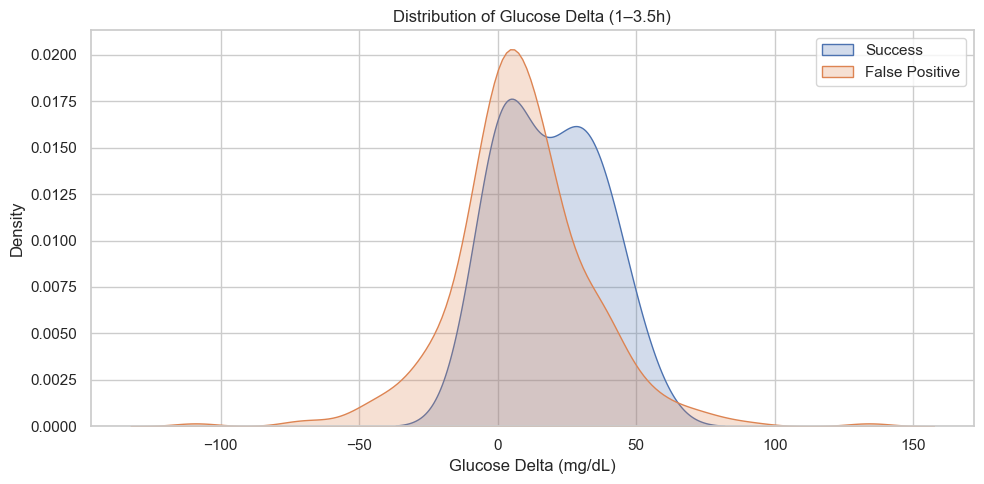

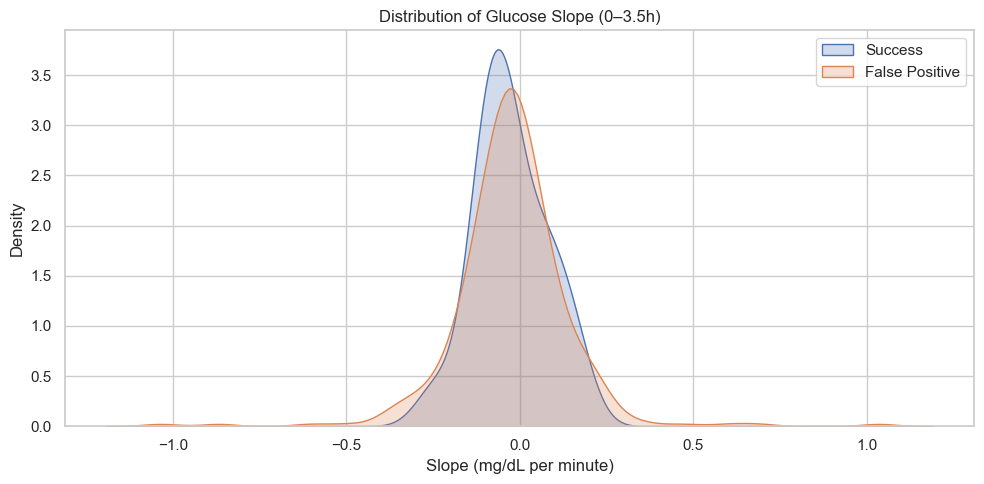

In [259]:
import matplotlib.pyplot as plt
import seaborn as sns

# 성공과 FP 그룹 구분
success_df = test_df_clean[test_df_clean["Success"] == True]
fp_df = test_df_clean[test_df_clean["FP"] == True]

sns.set(style="whitegrid")

# 1. Glucose_Delta_1_3.5h 시각화
plt.figure(figsize=(10, 5))
sns.kdeplot(success_df["Glucose_Delta_1_3.5h"], label="Success", fill=True)
sns.kdeplot(fp_df["Glucose_Delta_1_3.5h"], label="False Positive", fill=True)
plt.title("Distribution of Glucose Delta (1–3.5h)")
plt.xlabel("Glucose Delta (mg/dL)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# 2. Glucose_Slope_0_3.5h 시각화
plt.figure(figsize=(10, 5))
sns.kdeplot(success_df["Glucose_Slope_0_3.5h"], label="Success", fill=True)
sns.kdeplot(fp_df["Glucose_Slope_0_3.5h"], label="False Positive", fill=True)
plt.title("Distribution of Glucose Slope (0–3.5h)")
plt.xlabel("Slope (mg/dL per minute)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


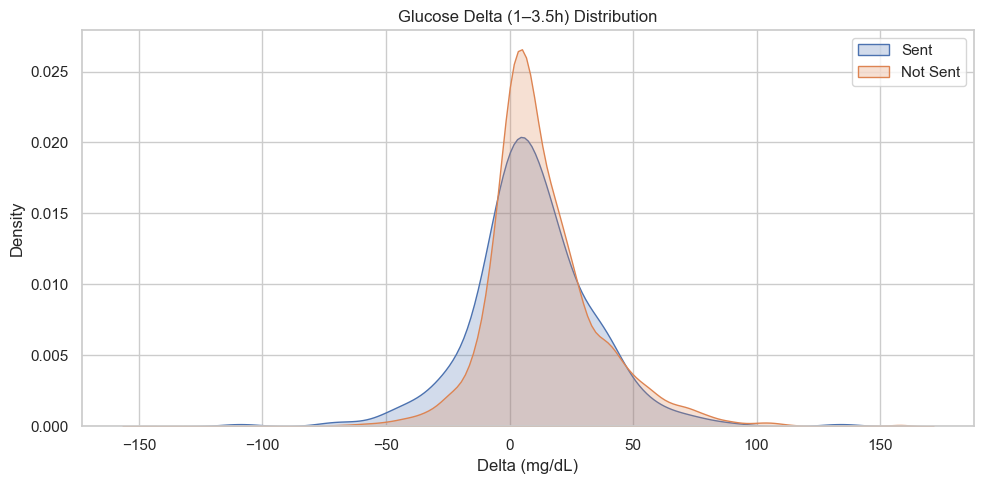

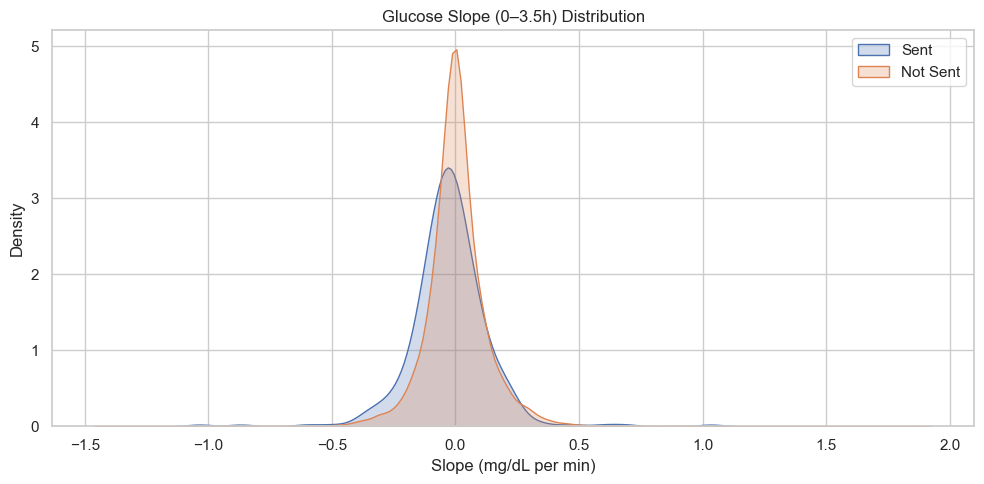

In [261]:
import matplotlib.pyplot as plt
import seaborn as sns

# 발송 그룹 전체
sent_df = test_df_clean[test_df_clean["send_msg"] == True]

# 비발송 그룹 전체
nonsent_df = test_df_clean[test_df_clean["send_msg"] == False]

# 시각화: Glucose Delta
plt.figure(figsize=(10, 5))
sns.kdeplot(sent_df["Glucose_Delta_1_3.5h"].dropna(), label="Sent", fill=True)
sns.kdeplot(nonsent_df["Glucose_Delta_1_3.5h"].dropna(), label="Not Sent", fill=True)
plt.title("Glucose Delta (1–3.5h) Distribution")
plt.xlabel("Delta (mg/dL)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 시각화: Glucose Slope
plt.figure(figsize=(10, 5))
sns.kdeplot(sent_df["Glucose_Slope_0_3.5h"].dropna(), label="Sent", fill=True)
sns.kdeplot(nonsent_df["Glucose_Slope_0_3.5h"].dropna(), label="Not Sent", fill=True)
plt.title("Glucose Slope (0–3.5h) Distribution")
plt.xlabel("Slope (mg/dL per min)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# SHAP Waterfall plot

In [ ]:
# 예: 첫 번째 메시지 발송 row 사용
i = msg_test_rows.loc[0, "index"]  # 원래 인덱스 (X_test 기준)

import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# SHAP Waterfall Plot
shap.initjs()
shap.plots.waterfall(shap.Explanation(
    values=shap_values[1][i],
    base_values=explainer.expected_value[1],
    data=X_test.iloc[i],
    feature_names=X_test.columns
))


In [ ]:
from shap import TreeExplainer

explainer = shap.TreeExplainer(model)  # model은 RandomForestClassifi

# 확률 0.5 넘는 인덱스 추출
high_prob_indices = np.where(y_proba > 0.5)[0]

if len(high_prob_indices) == 0:
    print("❌ No samples found with predicted probability > 0.5.")
else:
    idx = high_prob_indices[4]  # index 변경 가능
    x_row = X_test.iloc[[idx]]

    # SHAP 값 계산
    shap_values = explainer.shap_values(x_row)

    # Waterfall plot (class 1 기준으로)
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values[1][0],  # class 1의 shap 값
            base_values=explainer.expected_value[1],
            data=x_row.values[0],
            feature_names=x_row.columns.tolist()
        )
    )
